In [ ]:
from jax import config
config.update('jax_enable_x64', True)

from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from uncprop.models.elliptic_pde.experiment import (
    PDEReplicate,
    summarize_status,
    load_rep,
    samp_trace,
    samp_pair_plot,
    plot_surrogate_pred,
    estimate_mahalanobis_coverage,
)

experiment_name = 'pde_experiment'
base_dir = Path('/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates')
base_out_dir = base_dir / 'out'

/projectnb/dietzelab/arober/Bayesian-inference-with-surrogates/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
summarize_status(base_out_dir, experiment_name, n_design=[10, 20, 30])

n_design = 10: 97 of 98 completed.
n_design = 20: 90 of 91 completed.
n_design = 30: 100 of 100 completed.


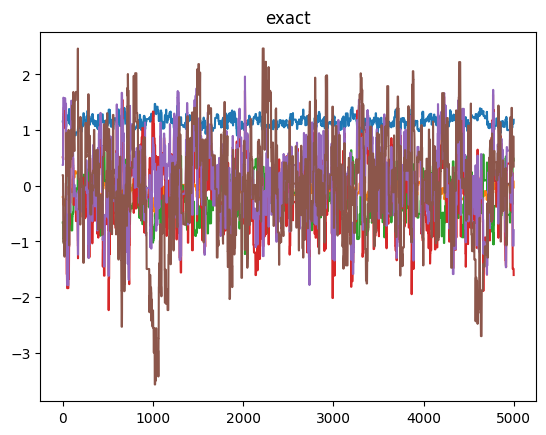

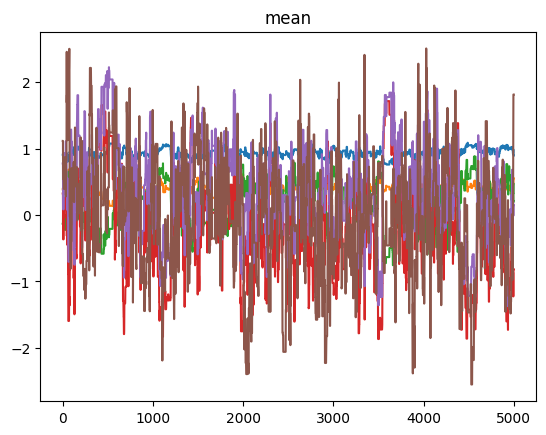

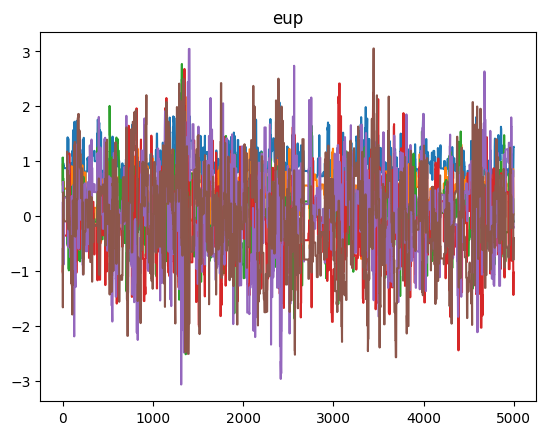

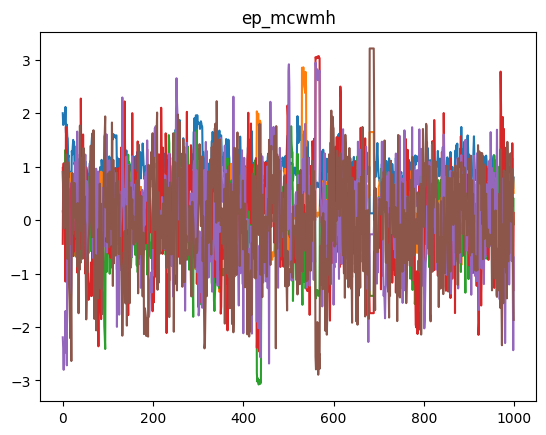

In [12]:
n_design = 30
rep_idx = 76

samp_trace(base_out_dir, experiment_name, n_design, rep_idx)

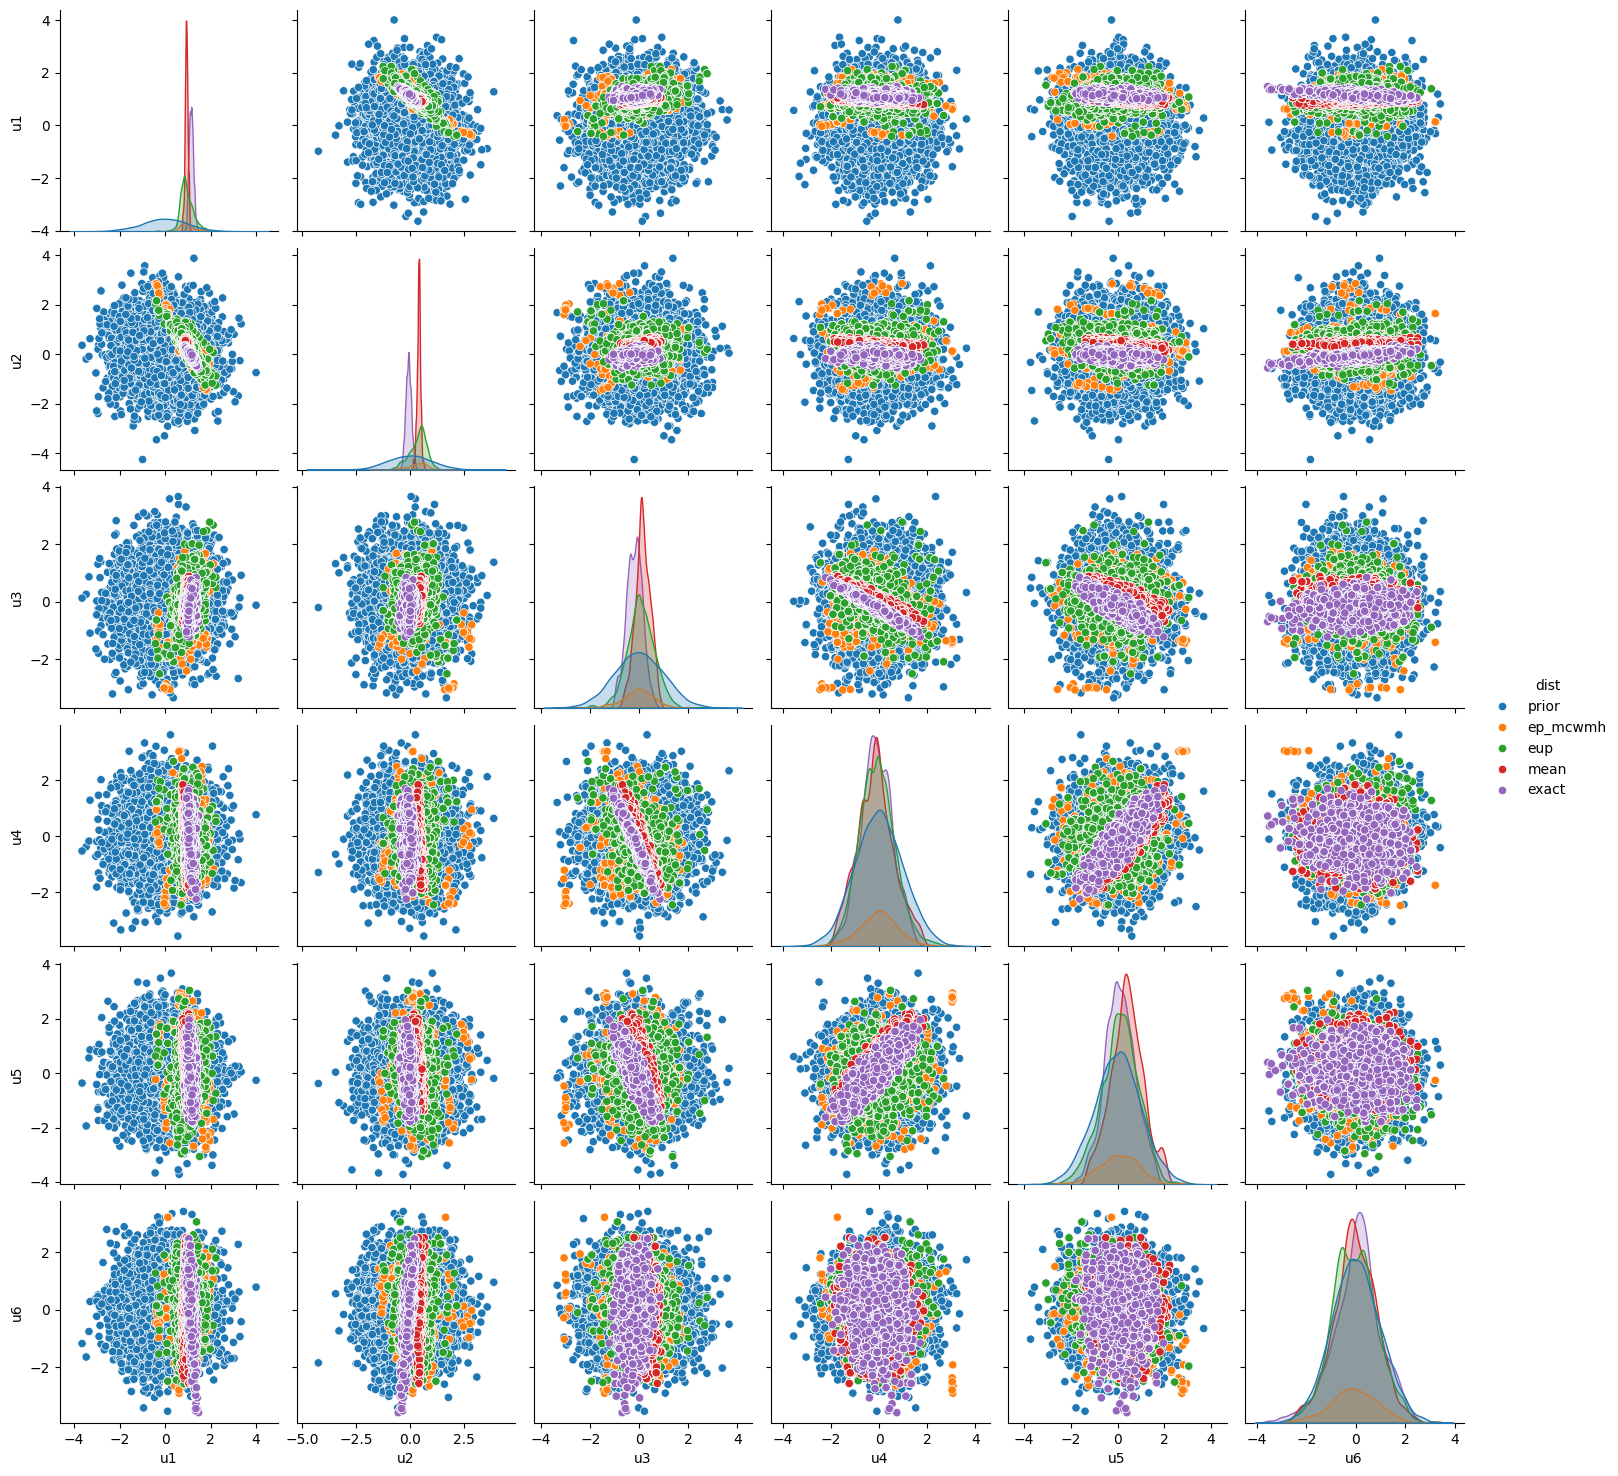

In [13]:
samp_pair_plot(base_out_dir, experiment_name, 
               key=jr.key(0), 
               n_design=n_design, 
               rep_idx=rep_idx)

	Fitting surrogate


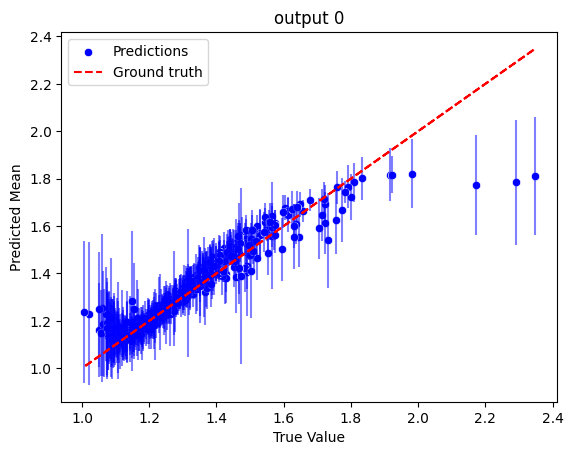

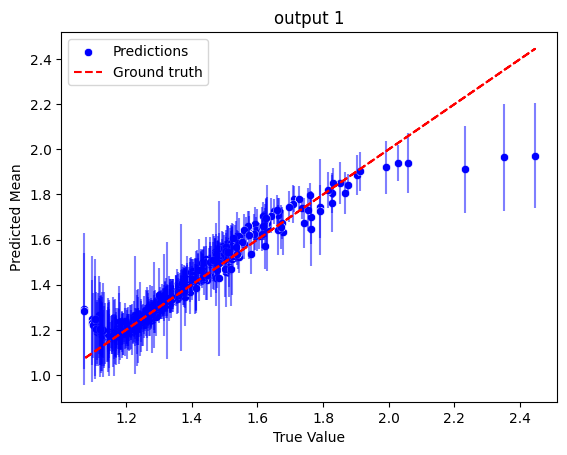

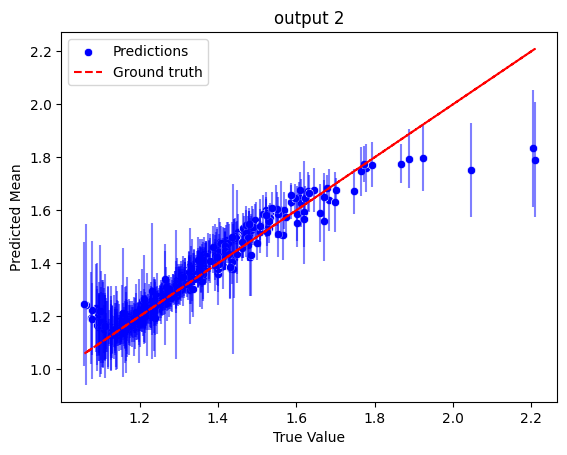

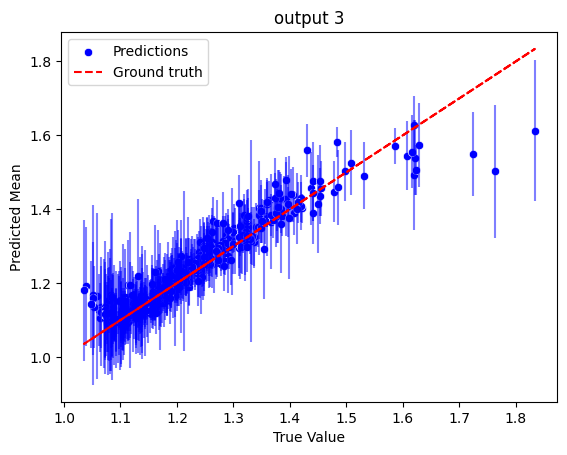

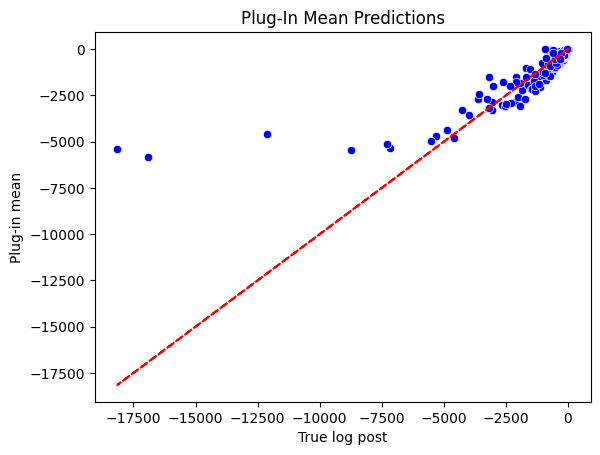

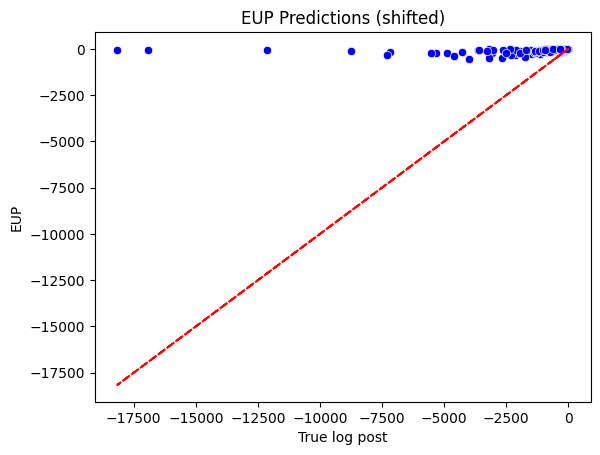

In [19]:
plot_surrogate_pred(base_out_dir, experiment_name, 10, 1)

In [ ]:
n_test = 500
key = jr.key(34252)

n_design = 30

key, key_rep = jr.split(key, 2)
rep = PDEReplicate(key=key,
                   out_dir=None,
                   n_design=n_design,
                   num_rff=1000,
                   design_method='lhc',
                   write_to_file=False)

key, key_samp = jr.split(key, 2)

test_inputs = rep.posterior.prior.sample_lhc(key, n_test)
true_forward = rep.posterior.likelihood.forward(test_inputs)
true_llik = rep.posterior.likelihood.observable_to_logdensity(true_forward)

pred = rep.posterior_surrogate.surrogate(test_inputs)
mean_forward = pred.mean.T
sd_forward = pred.stdev.T

In [ ]:
import seaborn as sns

for i in range(true_forward.shape[1]):
    sns.scatterplot(x=true_forward[:,i], y=mean_forward[:,i], color='blue', label="Predictions")
    plt.errorbar(true_forward[:,i], mean_forward[:,i], yerr=2*sd_forward[:,i], fmt='none', ecolor='blue', alpha=0.5)
    plt.plot(true_forward[:,i], true_forward[:,i], 'r--', label="Ground truth")
    plt.xlabel("True Value")
    plt.ylabel("Predicted Mean")
    plt.legend()
    plt.title(f'output {i}')
    plt.show()

In [ ]:
for i in range(test_inputs.shape[1]):
    x = jnp.linspace(-3, 3, num=test_inputs.shape[0])
    test_inputs_i = test_inputs.at[:,i].set(x)
    true_forward_i = rep.posterior.likelihood.forward(test_inputs_i)
    plt.plot(x, true_forward_i[:,3])
    plt.show()

In [ ]:
import typing as tp
from jaxtyping import Num
from gpjax.typing import ScalarFloat, Float, Array
from gpjax.parameters import Parameter, Real
from gpjax.mean_functions import AbstractMeanFunction

class LinearMeanFunction(AbstractMeanFunction):
    """
    Note that the batch output dimension is defined as the leading dimension,
    but the output of evaluating the mean function puts the batch dimension
    last. This is to align with the batch GP conventions in gpjax_multioutput.py
    """
    def __init__(
        self,
        intercept: tp.Union[ScalarFloat, Float[Array, " O"], Parameter] = 0.0,
        slope: tp.Union[ScalarFloat, Float[Array, " O D"], Parameter] = 0.0,
        quad_slope: tp.Union[ScalarFloat, Float[Array, " O D"], Parameter] = 0.0,
    ):
        if isinstance(intercept, Parameter):
            self.intercept = intercept
        else:
            self.intercept = Real(jnp.array(intercept))

        if isinstance(slope, Parameter):
            self.slope = slope
        else:
            self.slope = Real(jnp.array(slope))

        if isinstance(quad_slope, Parameter):
            self.quad_slope = quad_slope
        else:
            self.quad_slope = Real(jnp.array(quad_slope))

    def __call__(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        return self.intercept.get_value() + jnp.dot(x, self.slope.get_value().T) + jnp.dot(x**2, self.quad_slope.get_value().T)

In [ ]:
test1 = LinearMeanFunction(intercept=jnp.array(1),
                          slope=jnp.array([1, 2, 3]),
                          quad_slope=jnp.array([.1, .2, .3]))

test2 = LinearMeanFunction(intercept=jnp.array(2),
                          slope=jnp.array([4, 5, 6]),
                          quad_slope=jnp.array([.4,.5,10]))

test3 = LinearMeanFunction(intercept=jnp.array([1, 2]),
                           slope=jnp.array([[1, 4], [2, 5], [3,6]]),
                           quad_slope=jnp.array([[.1, .4], [.2, .5], [.3,.6]]))

In [ ]:
u = jr.uniform(key, (4, 3))

print(test1(u))
print(test2(u))
print(test3(u))

In [ ]:
summarize_status(4, base_out_dir)

In [ ]:
rep_idx = 1
n_design = 4
key = jr.key(23532)

samp_trace(n_design, rep_idx, base_out_dir)
samp_pair_plot(key, n_design, rep_idx, base_out_dir)

### END TEMP

In [ ]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import jax
import jax.numpy as jnp
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.distributions import MultivariateNormal

from uncprop.core.distribution import GaussianFromNumpyro
from uncprop.core.samplers import sample_distribution
from uncprop.utils.plot import set_plot_theme, smart_subplots
from uncprop.utils.grid import plot_coverage_curve_reps
from uncprop.models.elliptic_pde.inverse_problem import (
    PDESettings,
    generate_pde_inv_prob_rep,
    plot_inverse_problem_setup,
)

colors = set_plot_theme()
base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

from pde_model import (
    get_discrete_source, 
    solve_pde, 
    solve_pde_vmap,
)

In [ ]:
# settings 

key = jr.key(5232214)
noise_sd = 1e-2
n_kl_modes = 6
obs_locations = jnp.array([10, 30, 60, 75])

inv_prob_settings = {
    'noise_cov' : noise_sd**2 * jnp.identity(len(obs_locations)),
    'n_kl_modes': n_kl_modes,
    'obs_locations': obs_locations,
    'settings': PDESettings()
}
inv_prob_settings['key'] = key

In [ ]:
posterior, gp_prior, eig_info, ground_truth = generate_pde_inv_prob_rep(**inv_prob_settings)

In [ ]:
key, key_plot = jr.split(key)

fig, ax = plot_inverse_problem_setup(key=key_plot,
                                     posterior=posterior,
                                     ground_truth=ground_truth,
                                     observation=posterior.likelihood.observation,
                                     n_samp=3)

In [ ]:
key, key_prior, key_mcmc = jr.split(key, 3)

positions, states, warmup_samp, prop_cov = sample_distribution(
    key=key,
    dist=posterior,
    initial_position=posterior.prior.sample(key_prior).squeeze(),
    n_samples=10_000,
    n_warmup=10_000
)

In [ ]:
for i in range(posterior.dim):
    plt.plot(positions[:,i])